In [1]:
# Import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

In [2]:
# Set view options
pd.set_option("display.max_rows", 500)

In [3]:
# Create spark session
spark = SparkSession.builder.getOrCreate()

In [4]:
# Read in file as spark dataframe
slurm_jobs = spark.read.option('header', True).csv('../data/fullsample.csv')
slurm_jobs.show(5)

+----------+---------+-------------------+-------------------+--------+---------+-----------+-----------+-----+----+------------+--------+
|     JOBID|    STATE|              BEGIN|                END|  REQMEM|  USEDMEM|    REQTIME|   USEDTIME|NODES|CPUS|   PARTITION|EXITCODE|
+----------+---------+-------------------+-------------------+--------+---------+-----------+-----------+-----+----+------------+--------+
|  30616928|  RUNNING|2021-07-31T22:15:00|            Unknown|  2048Mn|        0|   10:04:00|67-22:14:22|    1|   1|  production|     0:0|
|  30853133|COMPLETED|2021-08-06T11:36:09|2021-09-05T11:36:32|262144Mn|20604.62M|30-00:00:00|30-00:00:23|    1|   1|cgw-platypus|     0:0|
|  30858137|COMPLETED|2021-08-06T19:04:39|2021-09-05T19:04:53|204800Mn|57553.77M|30-00:00:00|30-00:00:14|    1|  32|   cgw-tbi01|     0:0|
|  30935078|COMPLETED|2021-08-09T16:52:51|2021-09-07T20:52:55| 65536Mn|20577.96M|29-04:00:00|29-04:00:04|    1|   8|cgw-platypus|     0:0|
|31364111_2|COMPLETED|2021-

In [5]:
# Clean up dataframe
slurm_jobs = slurm_jobs.filter('END != "Unknown"')

In [6]:
# Aggregate exitcode counts
exitcodes = (slurm_jobs
             .groupBy('EXITCODE')
             .count()
             .sort('count', ascending = False)
             .toPandas()
)

exitcodes.head()

,EXITCODE,count
0,0:0,7383829
1,1:0,4958
2,0:15,1887
3,0:125,1739
4,0:9,1361


In [7]:
# Aggregate job completion counts by day
job_completions_by_day = (slurm_jobs
                          .groupBy(date_trunc('day', col('END')).alias('timestamp'))
                          .count()
                          .sort('timestamp')
                          .toPandas()
)

job_completions_by_day.head()

,timestamp,count
0,2020-10-01,33281
1,2020-10-02,30375
2,2020-10-03,15368
3,2020-10-04,17581
4,2020-10-05,24166


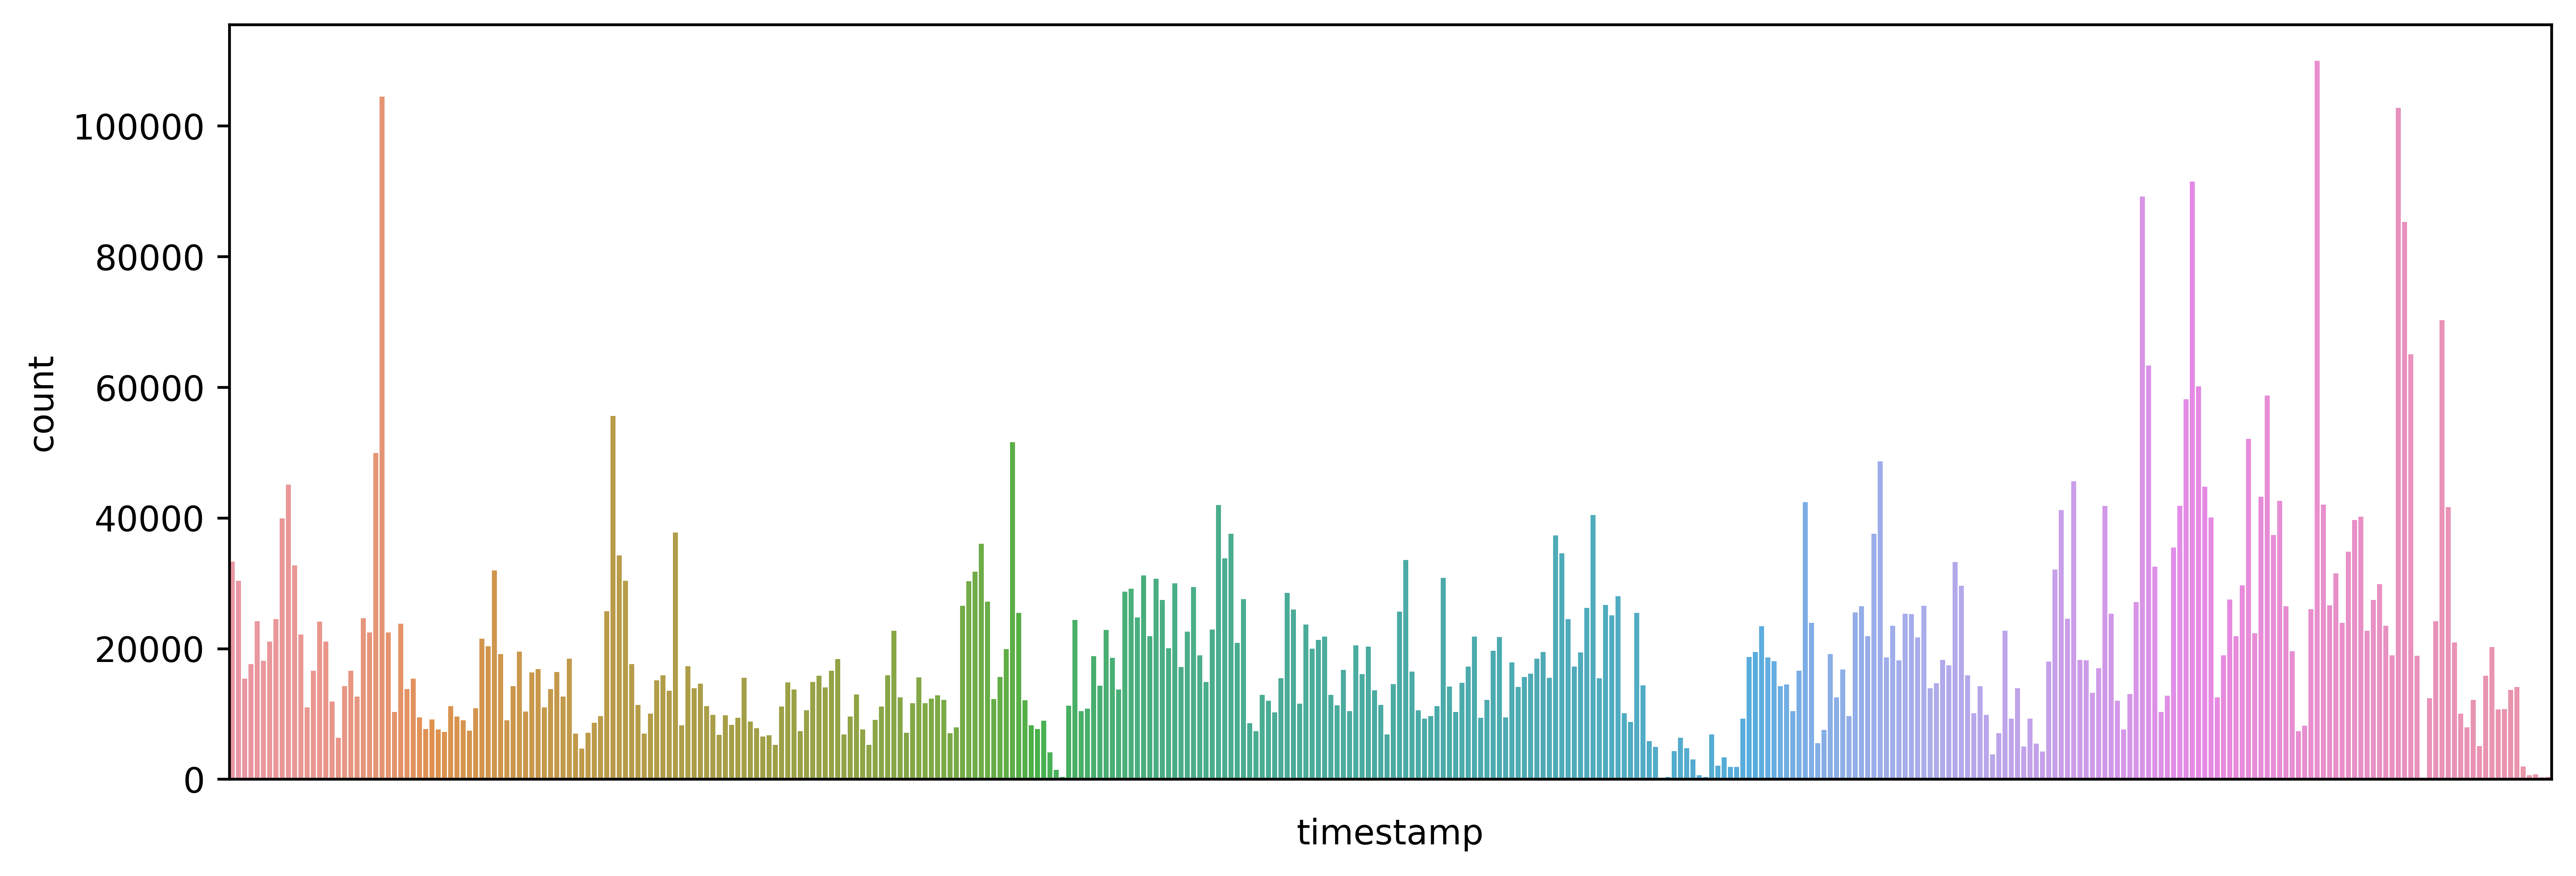

In [8]:
# Plot job completion counts by day
fig, ax = plt.subplots(figsize = (12, 4), dpi = 600)

sns.barplot(x = 'timestamp', y = 'count', data = job_completions_by_day)

ax.tick_params(axis = 'x', bottom = False)
ax.xaxis.set_ticklabels([])

plt.show()

In [9]:
# Aggregate job completion counts by hour
job_completions_by_hour = (slurm_jobs
                          .groupBy(date_trunc('hour', col('END')).alias('timestamp'))
                          .count()
                          .sort('timestamp')
                          .toPandas()
)

job_completions_by_hour.head()

,timestamp,count
0,2020-10-01 00:00:00,421
1,2020-10-01 01:00:00,1080
2,2020-10-01 02:00:00,1137
3,2020-10-01 03:00:00,1022
4,2020-10-01 04:00:00,1244


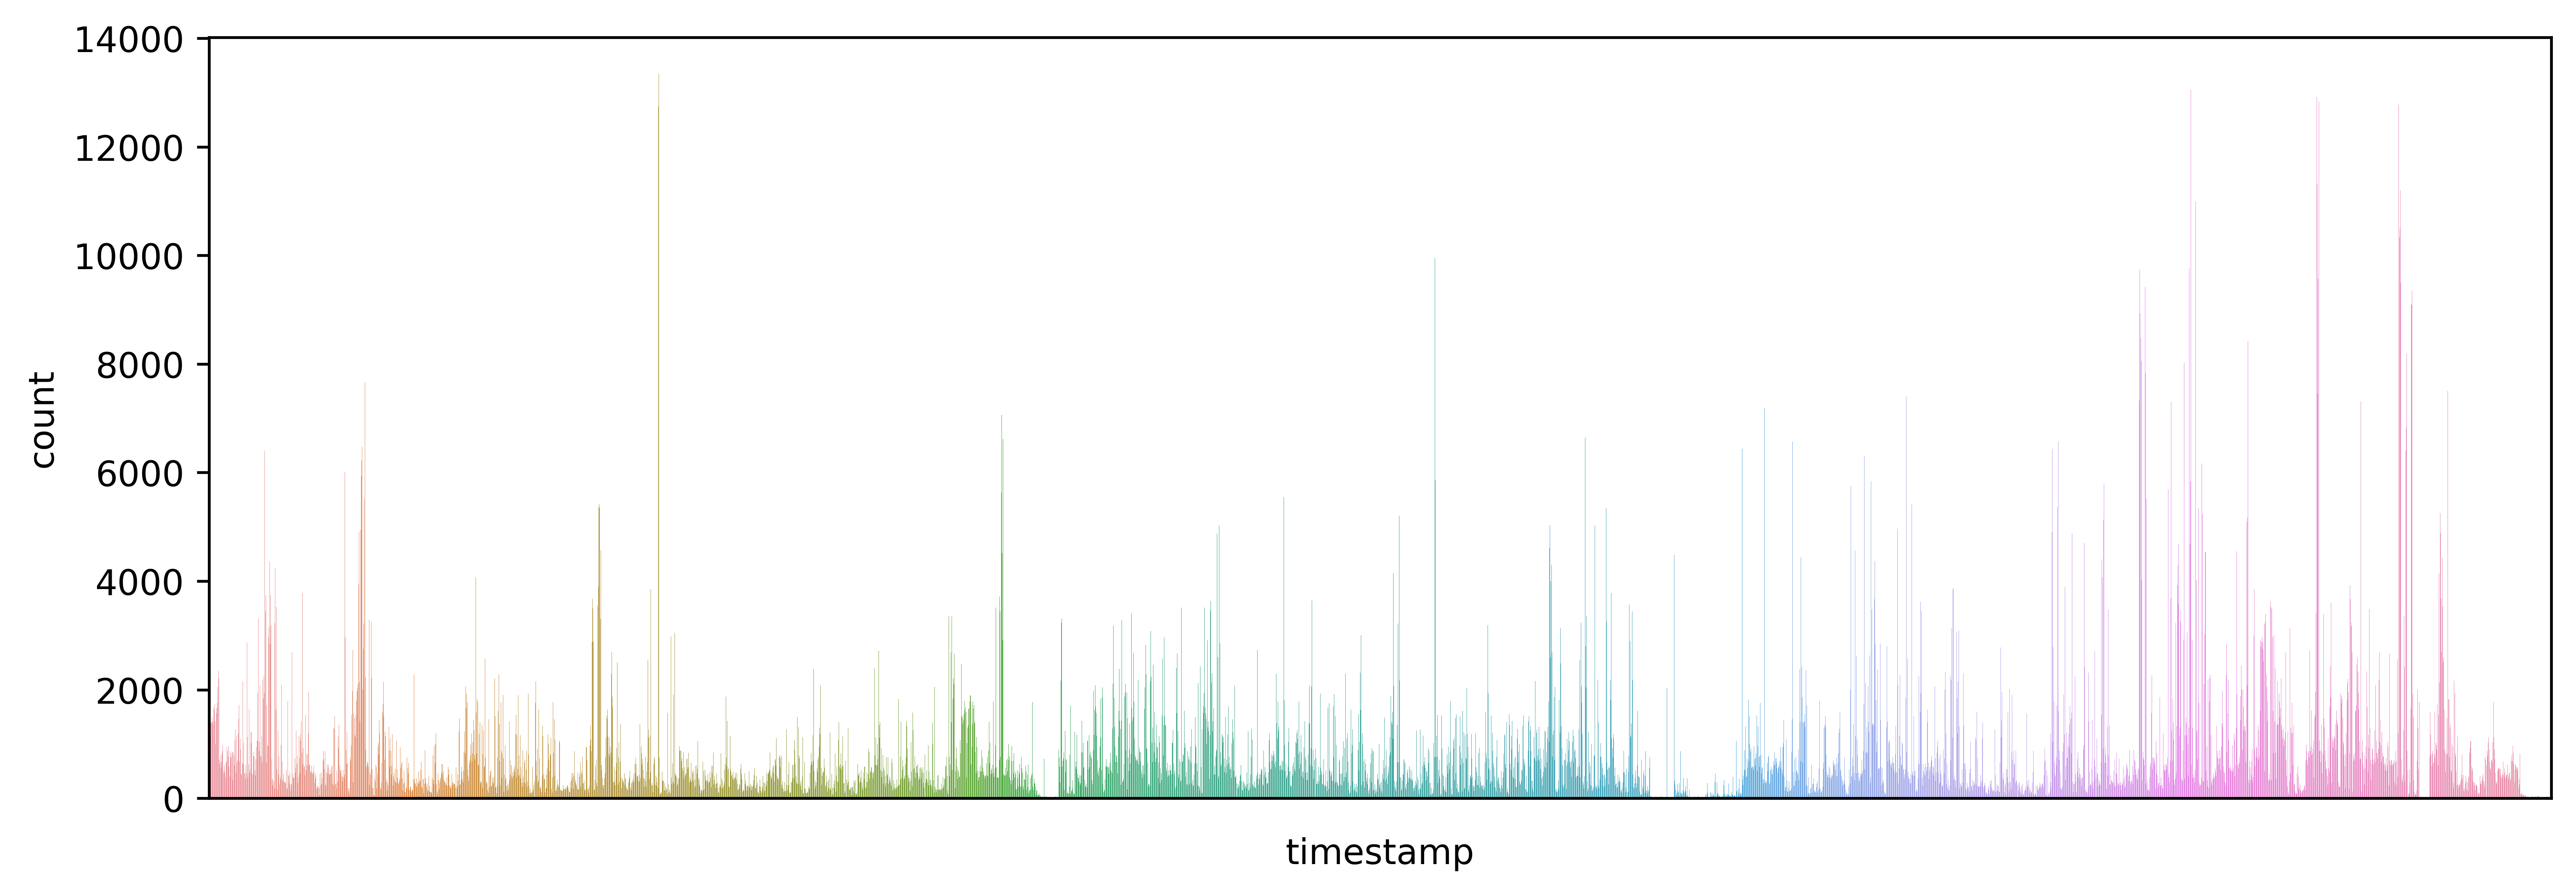

In [10]:
# Plot job completion counts by hour
fig, ax = plt.subplots(figsize = (12, 4), dpi = 600)

sns.barplot(x = 'timestamp', y = 'count', data = job_completions_by_hour)

ax.tick_params(axis = 'x', bottom = False)
ax.xaxis.set_ticklabels([])

plt.show()

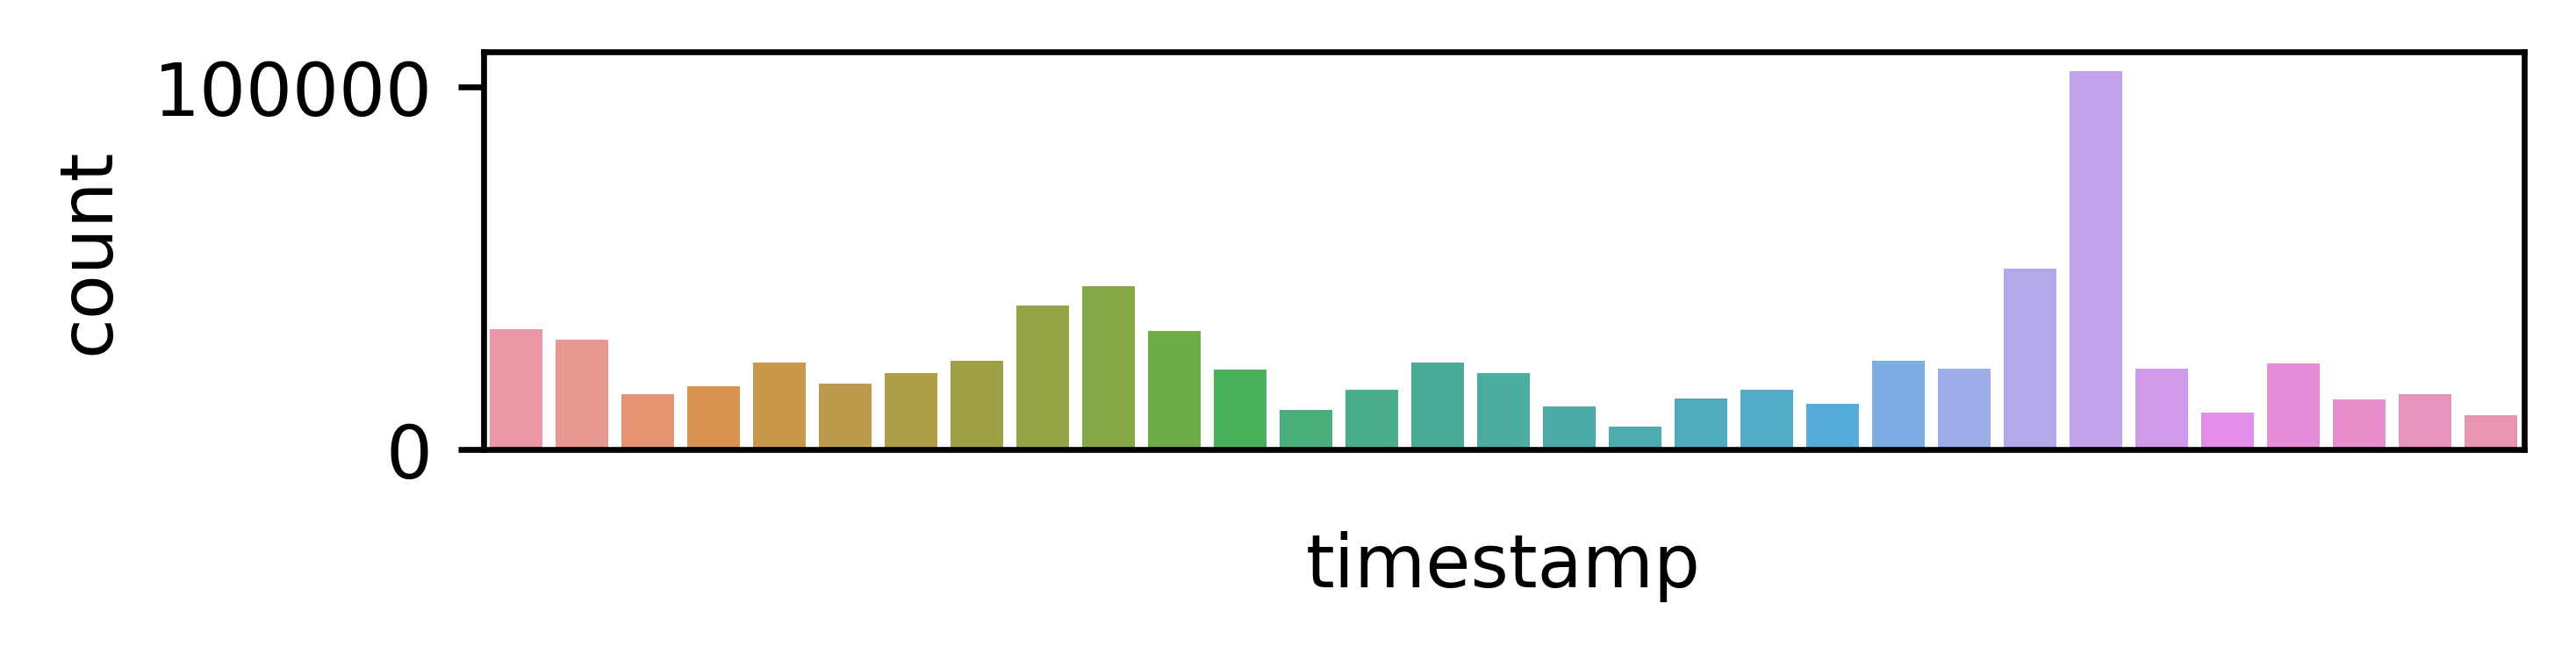

In [11]:
# Plot job completion counts by day for oct 2020
job_completions_by_day_oct_2020 = job_completions_by_day.set_index('timestamp').loc['2020-10']

fig, ax = plt.subplots(figsize = (5, 1), dpi = 600)

sns.barplot(x = job_completions_by_day_oct_2020.index, y = 'count', data = job_completions_by_day_oct_2020)

ax.tick_params(axis = 'x', bottom = False)
ax.xaxis.set_ticklabels([])

plt.show()

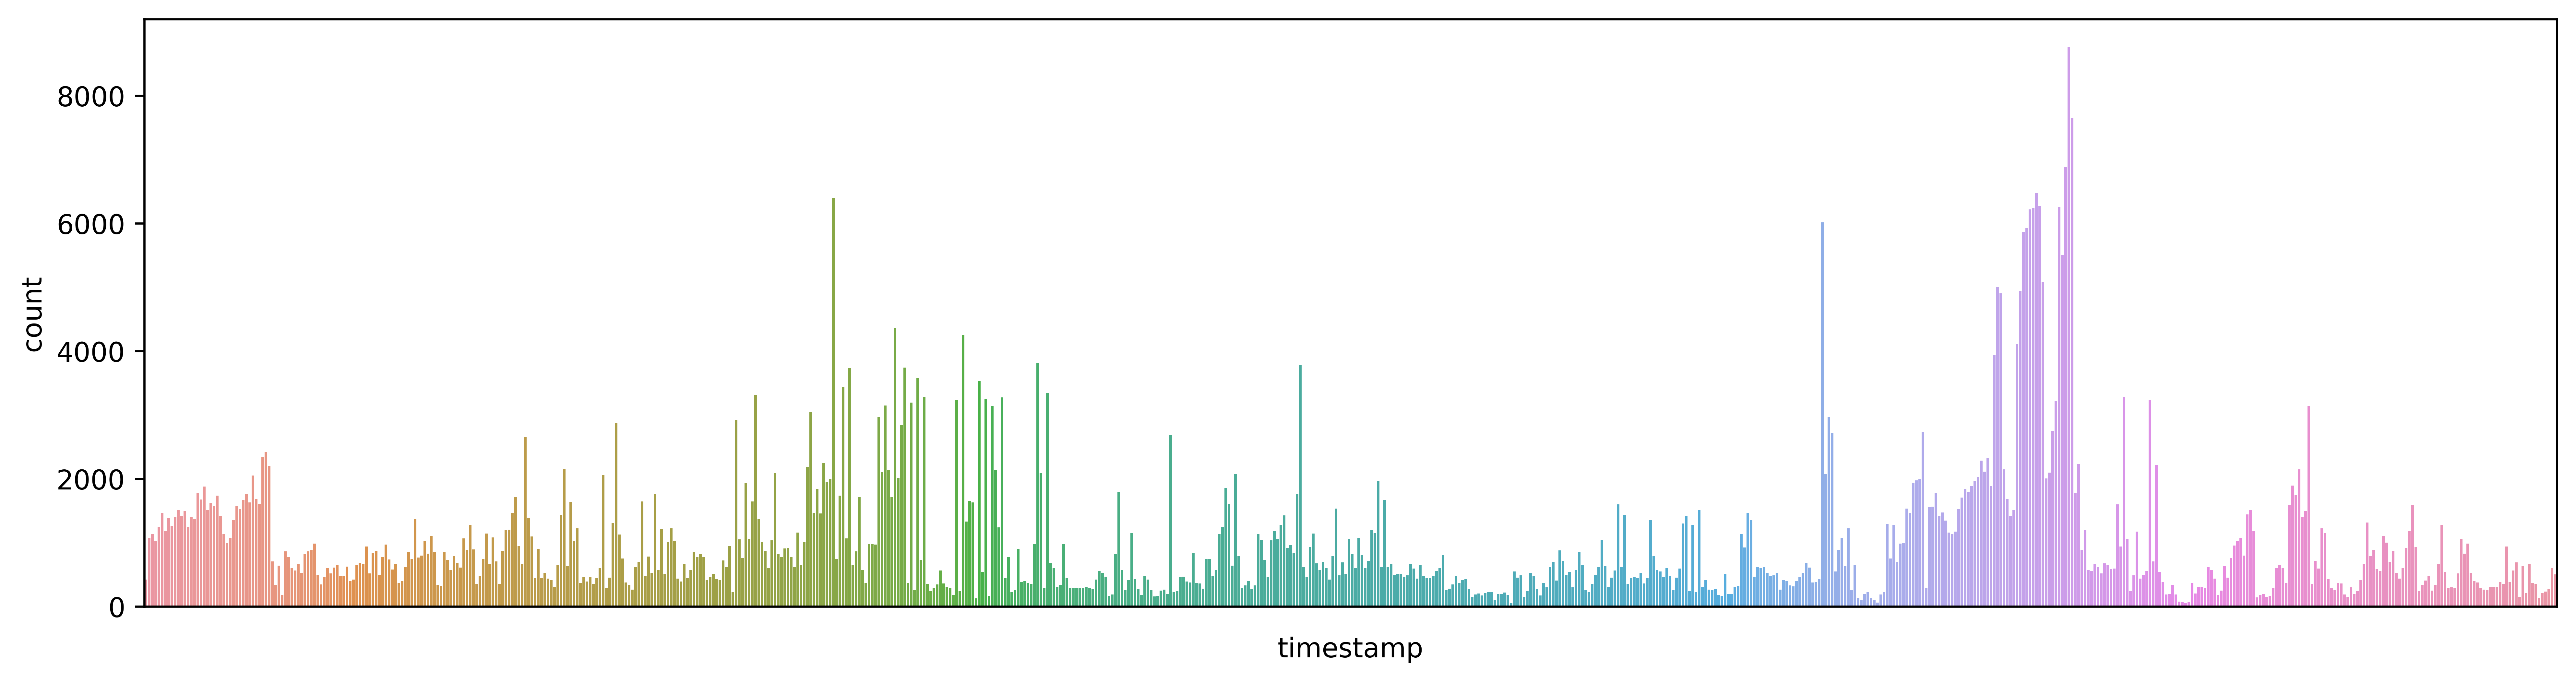

In [12]:
# Plot job completion counts by hour for oct 2020
job_completions_by_hour_oct_2020 = job_completions_by_hour.set_index('timestamp').loc['2020-10']

fig, ax = plt.subplots(figsize = (16, 4), dpi = 600)

sns.barplot(x = job_completions_by_hour_oct_2020.index, y = 'count', data = job_completions_by_hour_oct_2020)

ax.tick_params(axis = 'x', bottom = False)
ax.xaxis.set_ticklabels([])

plt.show()

In [13]:
# Read in files as spark dataframes
ce5_log = (spark.read.option('delimiter', ' - ')
           .csv('../data/slurm_wrapper_ce5.log')
           .toDF('timestamp', 'user', 'retry_attempt', 'execution_time', 'returncode', 'command')
)
ce5_log.show(5)

ce6_log = (spark.read.option('delimiter', ' - ')
           .csv('../data/slurm_wrapper_ce6.log')
           .toDF('timestamp', 'user', 'retry_attempt', 'execution_time', 'returncode', 'command')
)
ce6_log.show(5)


+--------------------+------+-------------+--------------------+------------+--------------------+
|           timestamp|  user|retry_attempt|      execution_time|  returncode|             command|
+--------------------+------+-------------+--------------------+------------+--------------------+
|2020-10-16 08:15:...|user 0|      retry 0|time 0.0734755992...|returncode 0|command ['/usr/bi...|
|2020-10-16 08:18:...|user 0|      retry 0|time 0.1836323738...|returncode 0|command ['/usr/bi...|
|2020-10-16 08:22:...|user 0|      retry 0|time 0.0754711627...|returncode 0|command ['/usr/bi...|
|2020-10-16 08:25:...|user 0|      retry 0|time 0.0948436260...|returncode 0|command ['/usr/bi...|
|2020-10-16 08:31:...|user 0|      retry 0|time 0.0749878883...|returncode 0|command ['/usr/bi...|
+--------------------+------+-------------+--------------------+------------+--------------------+
only showing top 5 rows

+--------------------+---------+-------------+--------------------+------------+----

In [14]:
# Clean up dataframes
ce5_log = ce5_log.withColumn('timestamp', to_timestamp(col('timestamp')))
ce5_log = ce5_log.withColumn('user', regexp_replace('user', 'user ', '').cast('int'))
ce5_log = ce5_log.withColumn('retry_attempt', regexp_replace('retry_attempt', 'retry ', '').cast('int'))
ce5_log = ce5_log.withColumn('execution_time', regexp_replace('execution_time', 'time ', '').cast('int'))
ce5_log = ce5_log.withColumn('returncode', regexp_replace('returncode', 'returncode ', '').cast('int'))
ce5_log = ce5_log.withColumn('command', regexp_replace('command', 'command ', ''))

ce6_log = ce6_log.withColumn('timestamp', to_timestamp(col('timestamp')))
ce6_log = ce6_log.withColumn('user', regexp_replace('user', 'user ', '').cast('int'))
ce6_log = ce6_log.withColumn('retry_attempt', regexp_replace('retry_attempt', 'retry ', '').cast('int'))
ce6_log = ce6_log.withColumn('execution_time', regexp_replace('execution_time', 'time ', '').cast('int'))
ce6_log = ce6_log.withColumn('returncode', regexp_replace('returncode', 'returncode ', '').cast('int'))
ce6_log = ce6_log.withColumn('command', regexp_replace('command', 'command ', ''))

In [15]:
# Filter log entries where slurm scheduler was unresponsive
ce5_unresponsive = (ce6_log
                    .filter('user = 9204')
                    .filter('returncode = 1')
                    .filter('execution_time >= 15')
                    .filter(col('command').contains('sbatch'))
                    .toPandas()
)

ce6_unresponsive = (ce6_log
                    .filter('user = 9204')
                    .filter('returncode = 1')
                    .filter('execution_time >= 15')
                    .filter(col('command').contains('sbatch'))
                    .toPandas()
)